In [1]:
!wget "https://prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com/dtvbwrhznz-1.zip" -O medicinal_dataset.zip


--2025-11-23 13:19:04--  https://prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com/dtvbwrhznz-1.zip
Resolving prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com (prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com)... 3.5.69.143, 3.5.71.130, 52.218.118.90, ...
Connecting to prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com (prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com)|3.5.69.143|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2163452599 (2.0G) [application/zip]
Saving to: ‘medicinal_dataset.zip’

medicinal_dataset.z 100%[===================>]   2.01G  23.8MB/s    in 83s     

2025-11-23 13:20:28 (24.8 MB/s) - ‘medicinal_dataset.zip’ saved [2163452599/2163452599]



In [2]:
import zipfile

zip_path = "medicinal_dataset.zip"
extract_path = "/content/medicinal"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Extracted!")

Extracted!


In [3]:
import os

base_path = "/content/medicinal"

for root, dirs, files in os.walk(base_path):
    print("Root:", root)
    print("Dirs:", dirs)
    print("Files:", files[:10])
    print("-" * 60)
    break

Root: /content/medicinal
Dirs: ['MED117_Medicinal Plant Leaf Dataset & Name Table']
Files: []
------------------------------------------------------------


In [4]:
import os
from pathlib import Path
import sys
import subprocess
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf


# 1) LOCATE dataset root

EXTRACTED_ROOT = Path("/content/medicinal") / "MED117_Medicinal Plant Leaf Dataset & Name Table"

if not EXTRACTED_ROOT.exists():
    raise SystemExit(f"Dataset root not found: {EXTRACTED_ROOT}\nMake sure you've extracted the ZIP to /content/medicinal")

print("Using dataset root:", EXTRACTED_ROOT)


Using dataset root: /content/medicinal/MED117_Medicinal Plant Leaf Dataset & Name Table


In [5]:
IMG_ROOT = EXTRACTED_ROOT / "MED 117 Leaf Species" / "Raw leaf image set of Medicinal plants"
print("Image root chosen:", IMG_ROOT)


# 3) List class directories & counts

def is_image_file(p: Path):
    return p.suffix.lower() in {".jpg", ".jpeg", ".png", ".bmp", ".tiff"}

class_dirs = sorted([d for d in IMG_ROOT.iterdir() if d.is_dir()])
if len(class_dirs) == 0:

    for child in IMG_ROOT.iterdir():
        if child.is_dir():
            cand = [d for d in child.iterdir() if d.is_dir()]
            if cand:
                class_dirs = sorted(cand)
                IMG_ROOT = child
                break

if len(class_dirs) == 0:
    raise SystemExit("No class subfolders found inside dataset. Please check the extracted folders and try again.")

print(f"Found {len(class_dirs)} class folders (showing up to 20):")
for d in class_dirs[:20]:
    cnt = sum(1 for p in d.rglob("*") if is_image_file(p))
    print(f" - {d.name}: {cnt} images")


rows = []
for d in class_dirs:
    for p in d.rglob("*"):
        if is_image_file(p):
            rows.append((str(p), d.name))
df = pd.DataFrame(rows, columns=["filepath","label"])
print("Total images found:", len(df))


Image root chosen: /content/medicinal/MED117_Medicinal Plant Leaf Dataset & Name Table/MED 117 Leaf Species/Raw leaf image set of Medicinal plants
Found 87 class folders (showing up to 20):
 - Abelmoschus moschatus medik(Ambrette ): 601 images
 - Aegle marmelos (L.) Corrêa(Wood apple): 601 images
 - Aerva sanguinolenta(Karadia): 540 images
 - Aloe vera (L.) Burm.F(Aloe Vera): 465 images
 - Alpinia galanga (L.) Willd(Blue ginger): 536 images
 - Andrographis paniculata (Burm.F.) Wall(Green Chirayta): 400 images
 - Aquilaria malaccensis(Eagle wood): 800 images
 - Aristolochia indica L(Indian Birthwort): 400 images
 - Artemisia absinthium L(Common Wormwood): 516 images
 - Asparagus officinalis L(wild asparagus): 1000 images
 - Azadirachta indica[Meliaceae](Indian lilac): 1265 images
 - Bacopa monnieri (L.) Wettst(Water hyssop): 700 images
 - Belamcanda chinensis (L.) Redouté(Blackberry Lily): 700 images
 - Bixa orellana L(Lipstick tree): 650 images
 - Boerhavia diffusa(Red spiderling): 400

In [6]:
# 4) Create train/val/test splits
try:
    import splitfolders
except Exception:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "split-folders"])
    import splitfolders

SPLIT_OUT = Path("/content/plant_data_split")
if SPLIT_OUT.exists():
    import shutil
    print(f"Removing existing split at {SPLIT_OUT}...")
    shutil.rmtree(SPLIT_OUT)

print("Creating train/val/test split (70/20/10). This may take a few minutes...")
splitfolders.ratio(str(IMG_ROOT), output=str(SPLIT_OUT), seed=42, ratio=(0.7,0.2,0.1))
print("Split created at", SPLIT_OUT)

train_dir = str(SPLIT_OUT / "train")
val_dir   = str(SPLIT_OUT / "val")
test_dir  = str(SPLIT_OUT / "test")
print("Train/Val/Test dirs:", train_dir, val_dir, test_dir)


Creating train/val/test split (70/20/10). This may take a few minutes...


Copying files: 68579 files [00:13, 4933.20 files/s]

Split created at /content/plant_data_split
Train/Val/Test dirs: /content/plant_data_split/train /content/plant_data_split/val /content/plant_data_split/test


In [7]:
# 4) Create train/val/test splits (stratified)
# -------------------------

try:
    import splitfolders
except Exception:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "split-folders"])
    import splitfolders

SPLIT_OUT = Path("/content/plant_data_split")
if SPLIT_OUT.exists():
    import shutil
    print(f"Removing existing split at {SPLIT_OUT}...")
    shutil.rmtree(SPLIT_OUT)

print("Creating train/val/test split (70/20/10). This may take a few minutes...")

splitfolders.ratio(str(IMG_ROOT), output=str(SPLIT_OUT), seed=42, ratio=(0.7,0.2,0.1))
print("Split created at", SPLIT_OUT)

train_dir = str(SPLIT_OUT / "train")
val_dir   = str(SPLIT_OUT / "val")
test_dir  = str(SPLIT_OUT / "test")
print("Train/Val/Test dirs:", train_dir, val_dir, test_dir)


Removing existing split at /content/plant_data_split...
Creating train/val/test split (70/20/10). This may take a few minutes...


Copying files: 68579 files [00:16, 4285.89 files/s]

Split created at /content/plant_data_split
Train/Val/Test dirs: /content/plant_data_split/train /content/plant_data_split/val /content/plant_data_split/test


In [8]:
# 5) tf.data datasets

IMG_SIZE = (224,224)
BATCH = 32

AUTOTUNE = tf.data.AUTOTUNE

def make_dataset(dir_path, image_size=IMG_SIZE, batch=BATCH, shuffle=True):
    ds = tf.keras.preprocessing.image_dataset_from_directory(
        dir_path,
        labels="inferred",
        label_mode="int",
        image_size=image_size,
        batch_size=batch,
        shuffle=shuffle
    )
    return ds

train_ds = make_dataset(train_dir, shuffle=True)
val_ds   = make_dataset(val_dir, shuffle=False)
test_ds  = make_dataset(test_dir, shuffle=False)
class_names = train_ds.class_names
num_classes = len(class_names)
print("Num classes:", num_classes)
print("Class names (first 30):", class_names[:30])


data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.12),
    tf.keras.layers.RandomZoom(0.08),
    tf.keras.layers.RandomTranslation(0.05, 0.05),
])

def prepare(ds, augment=False):
    ds = ds.map(lambda x,y: (tf.image.resize(x, IMG_SIZE), y), num_parallel_calls=AUTOTUNE)
    ds = ds.map(lambda x,y: (tf.cast(x, tf.float32) / 255.0, y), num_parallel_calls=AUTOTUNE)
    if augment:
        ds = ds.map(lambda x,y: (data_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE)
    return ds.prefetch(AUTOTUNE)

train_ds = prepare(train_ds, augment=True)
val_ds = prepare(val_ds, augment=False)
test_ds = prepare(test_ds, augment=False)


Found 47982 files belonging to 87 classes.
Found 13706 files belonging to 87 classes.
Found 6891 files belonging to 87 classes.
Num classes: 87
Class names (first 30): ['Abelmoschus moschatus medik(Ambrette )', 'Aegle marmelos (L.) Corrêa(Wood apple)', 'Aerva sanguinolenta(Karadia)', 'Aloe vera (L.) Burm.F(Aloe Vera)', 'Alpinia galanga (L.) Willd(Blue ginger)', 'Andrographis paniculata (Burm.F.) Wall(Green Chirayta)', 'Aquilaria malaccensis(Eagle wood)', 'Aristolochia indica L(Indian Birthwort)', 'Artemisia absinthium L(Common Wormwood)', 'Asparagus officinalis L(wild asparagus)', 'Azadirachta indica[Meliaceae](Indian lilac)', 'Bacopa monnieri (L.) Wettst(Water hyssop)', 'Belamcanda chinensis (L.) Redouté(Blackberry Lily)', 'Bixa orellana L(Lipstick tree)', 'Boerhavia diffusa(Red spiderling)', 'Breynia androgyna (L.) (Star gooseberry)', 'Brucea mollis Wall. Ex Kurz(Kunain)', 'Canna indica L.(Indian shot)', 'Cassia fistula L.(Golden Shower Tree)', 'Catharanthus roseus (L.) G.Don(Madagas

In [9]:
# 6) Model: EfficientNetB0 transfer learning + fine-tune
# -------------------------
from tensorflow.keras import layers, models, optimizers, callbacks

base_model = tf.keras.applications.EfficientNetB0(include_top=False, weights="imagenet", input_shape=(*IMG_SIZE,3), pooling="avg")
base_model.trainable = False

inputs = tf.keras.Input(shape=(*IMG_SIZE,3))
x = tf.keras.applications.efficientnet.preprocess_input(inputs)
x = base_model(x, training=False)
x = layers.Dropout(0.4)(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model = models.Model(inputs, outputs)

model.compile(optimizer=optimizers.Adam(learning_rate=1e-3),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
model.summary()


ckpt_path = "/content/best_effnet.h5"
ckpt = callbacks.ModelCheckpoint(ckpt_path, monitor="val_accuracy", save_best_only=True, verbose=1)
reduce_lr = callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6)
early = callbacks.EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True, verbose=1)


EPOCHS_HEAD = 6
history1 = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS_HEAD, callbacks=[ckpt, reduce_lr], verbose=2)


base_model.trainable = True
fine_tune_at = 150
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model.compile(optimizer=optimizers.Adam(learning_rate=1e-5),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

EPOCHS_FINE = 10
history2 = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS_FINE, callbacks=[ckpt, reduce_lr, early], verbose=2)


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 1280)           │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 87)             │       111,447 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,161,018 (15.87 MB)

 Trainable params: 111,447 (435.34 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

Epoch 1/6

Epoch 1: val_accuracy improved from -inf to 0.03940, saving model to /content/best_effnet.h5


1500/1500 - 840s - 560ms/step - accuracy: 0.0329 - loss: 4.3834 - val_accuracy: 0.0394 - val_loss: 4.3570 - learning_rate: 1.0000e-03
Epoch 2/6

Epoch 2: val_accuracy did not improve from 0.03940
1500/1500 - 809s - 539ms/step - accuracy: 0.0335 - loss: 4.3828 - val_accuracy: 0.0394 - val_loss: 4.3597 - learning_rate: 1.0000e-03
Epoch 3/6

Epoch 3: val_accuracy did not improve from 0.03940
1500/1500 - 614s - 409ms/step - accuracy: 0.0322 - loss: 4.3823 - val_accuracy: 0.0394 - val_loss: 4.3566 - learning_rate: 1.0000e-03
Epoch 4/6

Epoch 4: val_accuracy did not improve from 0.03940
1500/1500 - 621s - 414ms/step - accuracy: 0.0330 - loss: 4.3842 - val_accuracy: 0.0394 - val_loss: 4.3541 - learning_rate: 1.0000e-03
Epoch 5/6

Epoch 5: val_accuracy did not improve from 0.03940
1500/1500 - 614s - 410ms/step - accuracy: 0.0332 - loss: 4.3856 - val_accuracy: 0.0394 - val_loss: 4.3531 - learning_rate: 1.0000e-03
Epoch 6/6

Epoch 6: val_accuracy did not improve from 0.03940
1500/1500 - 607s - 4

1500/1500 - 620s - 413ms/step - accuracy: 0.0998 - loss: 3.8999 - val_accuracy: 0.0770 - val_loss: 4.2913 - learning_rate: 1.0000e-05
Epoch 3/10

Epoch 3: val_accuracy improved from 0.07705 to 0.09259, saving model to /content/best_effnet.h5


1500/1500 - 615s - 410ms/step - accuracy: 0.1472 - loss: 3.5797 - val_accuracy: 0.0926 - val_loss: 4.4300 - learning_rate: 1.0000e-05
Epoch 4/10

Epoch 4: val_accuracy did not improve from 0.09259
1500/1500 - 611s - 408ms/step - accuracy: 0.2016 - loss: 3.3098 - val_accuracy: 0.0897 - val_loss: 4.8323 - learning_rate: 1.0000e-05
Epoch 5/10

Epoch 5: val_accuracy improved from 0.09259 to 0.10674, saving model to /content/best_effnet.h5


1500/1500 - 614s - 410ms/step - accuracy: 0.2485 - loss: 3.0838 - val_accuracy: 0.1067 - val_loss: 4.6036 - learning_rate: 1.0000e-05
Epoch 6/10

Epoch 6: val_accuracy did not improve from 0.10674
1500/1500 - 614s - 409ms/step - accuracy: 0.2897 - loss: 2.9153 - val_accuracy: 0.0862 - val_loss: 5.1366 - learning_rate: 5.0000e-06
Epoch 7/10

Epoch 7: val_accuracy did not improve from 0.10674
1500/1500 - 621s - 414ms/step - accuracy: 0.3076 - loss: 2.8274 - val_accuracy: 0.0921 - val_loss: 4.9460 - learning_rate: 5.0000e-06
Epoch 8/10

Epoch 8: val_accuracy did not improve from 0.10674
1500/1500 - 615s - 410ms/step - accuracy: 0.3317 - loss: 2.7250 - val_accuracy: 0.0863 - val_loss: 5.2603 - learning_rate: 5.0000e-06
Epoch 8: early stopping
Restoring model weights from the end of the best epoch: 2.


Evaluating on test set...
216/216 - 25s - 117ms/step - accuracy: 0.1085 - loss: 4.6077
Test accuracy: 0.1085, Test loss: 4.6077
216/216 ━━━━━━━━━━━━━━━━━━━━ 23s 77ms/step
Classification report:
                                                             precision    recall  f1-score   support

                     Abelmoschus moschatus medik(Ambrette )       0.00      0.00      0.00        61
                     Aegle marmelos (L.) Corrêa(Wood apple)       0.00      0.00      0.00        61
                               Aerva sanguinolenta(Karadia)       0.00      0.00      0.00        54
                           Aloe vera (L.) Burm.F(Aloe Vera)       0.00      0.00      0.00        47
                    Alpinia galanga (L.) Willd(Blue ginger)       0.00      0.00      0.00        54
     Andrographis paniculata (Burm.F.) Wall(Green Chirayta)       0.00      0.00      0.00        40
                          Aquilaria malaccensis(Eagle wood)       0.00      0.00      0.00        

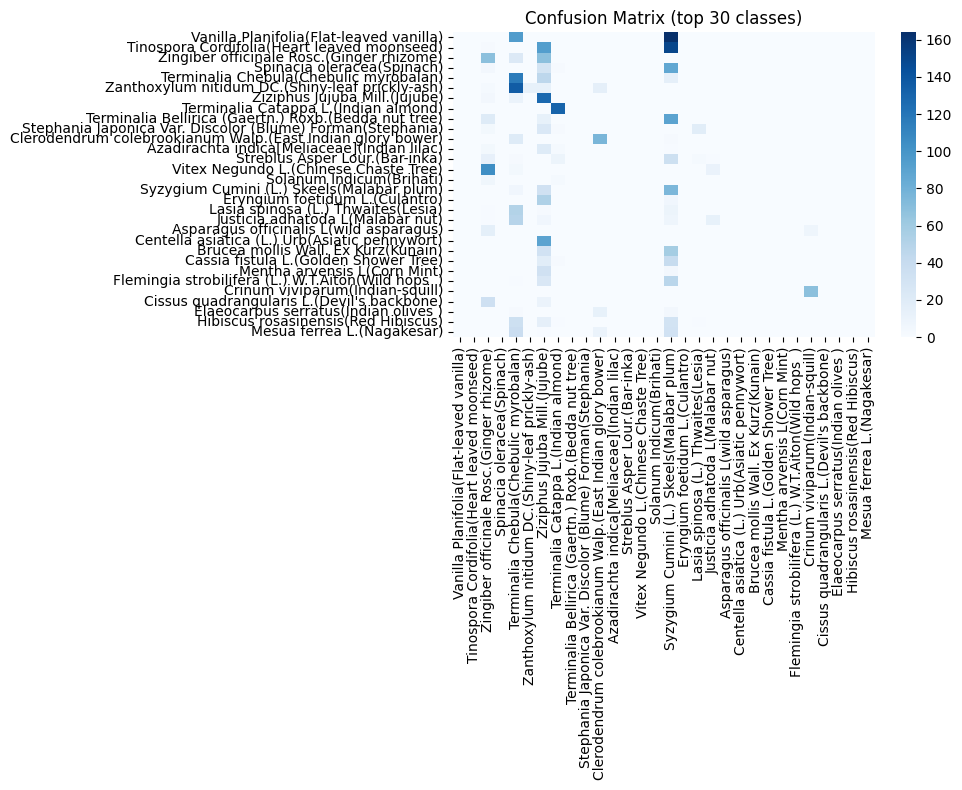

In [10]:
# 7) Evaluate on test set
# -------------------------

if os.path.exists(ckpt_path):
    model.load_weights(ckpt_path)
print("Evaluating on test set...")
test_loss, test_acc = model.evaluate(test_ds, verbose=2)
print(f"Test accuracy: {test_acc:.4f}, Test loss: {test_loss:.4f}")

# predictions and classification report
y_true = np.concatenate([y.numpy() for x,y in test_ds], axis=0)
y_pred_probs = model.predict(test_ds, verbose=1)
y_pred = np.argmax(y_pred_probs, axis=1)

from sklearn.metrics import classification_report, confusion_matrix
print("Classification report:")
print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))

# confusion matrix (all classes if <=30 else top 30)
cm = confusion_matrix(y_true, y_pred)
import seaborn as sns
plt.figure(figsize=(10,8))
if len(class_names) <= 30:
    sns.heatmap(cm, xticklabels=class_names, yticklabels=class_names, cmap="Blues")
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.title("Confusion Matrix")
else:
    # show top 30 classes by count
    counts = df['label'].value_counts()
    top30 = counts.index.tolist()[:30]
    idxs = [class_names.index(c) for c in top30]
    sub_cm = cm[np.ix_(idxs, idxs)]
    sns.heatmap(sub_cm, xticklabels=top30, yticklabels=top30, cmap="Blues")
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.title("Confusion Matrix (top 30 classes)")
plt.tight_layout()
plt.show()

In [11]:
# 8) Save final model
# -------------------------
MODEL_OUT = "/content/medicinal_effnet_model.keras" # Added .keras extension
model.save(MODEL_OUT)
print("Saved model to", MODEL_OUT)

Saved model to /content/medicinal_effnet_model.keras


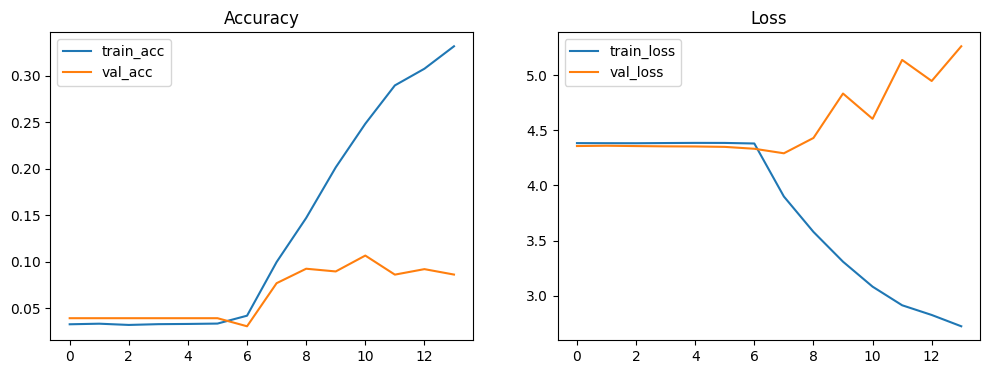

Done. If any error occurred, copy the error text and paste here and I will fix it.


In [12]:
# 9) Quick plots of training history (if available)
# -------------------------
def plot_history(h1, h2=None):
    hist = {}
    if h1:
        for k,v in h1.history.items():
            hist[k] = v
    if h2:
        for k,v in h2.history.items():
            hist.setdefault(k, []).extend(v)
    if not hist:
        return
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(hist.get('accuracy',[]), label='train_acc')
    plt.plot(hist.get('val_accuracy',[]), label='val_acc')
    plt.legend(); plt.title('Accuracy')
    plt.subplot(1,2,2)
    plt.plot(hist.get('loss',[]), label='train_loss')
    plt.plot(hist.get('val_loss',[]), label='val_loss')
    plt.legend(); plt.title('Loss')
    plt.show()

plot_history(history1, history2)
print("Done. If any error occurred, copy the error text and paste here and I will fix it.")